# Assignment 4

- Train a KNN Classifier on the MNIST Dataset

- Use Grid Search with cross-validation to find the best hyperparameter values for your KNN classifier. Focus on optimizing the n_neighbors and weights hyperparameters.

- Your goal is to achieve at least 97% accuracy on the test set. Use the optimal hyperparameters found in the grid search to fine-tune your model and test its performance on the test set.

- Compare the accuracy of your KNN classifier with the classifiers you fine-tuned in Lab 4, such as SGD and Random Forest Classifiers.

In [108]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score,precision_recall_curve, roc_curve, roc_auc_score,RocCurveDisplay,auc
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ShuffleSplit

import numpy as np
import os
import joblib

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [109]:
def save_model(model, name):
    name = name + ".pkl"
    p = os.path.join(MODELS_PATH, name)
    joblib.dump(model, p)

def load_model(model_name):
    model_name = model_name + ".pkl"
    p = os.path.join(MODELS_PATH, model_name)
    m = None
    if os.path.exists(p):
        m = joblib.load(p)
    return m

In [110]:
def draw_conf_max(mx, alp=0.9, fig_name=None):
    plt.matshow(mx, cmap=plt.cm.gray, alpha=alp)
    if fig_name:
        save_fig(fig_name, False)
    plt.show()

# Load data

In [111]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [112]:
X, y = mnist["data"], mnist["target"]

print("Train",X.shape, "Label",y.shape)

y = y.astype(np.uint8)

Train (70000, 784) Label (70000,)


# Split data

In [113]:
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a KNN classifier

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')

knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


# Check prediction

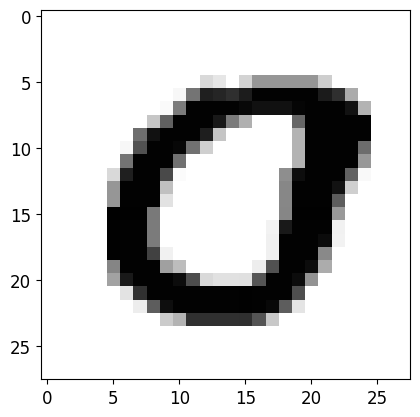

predict [0] label 0


In [116]:
i = 100
a = X_train[i]
a_reshaped = a.reshape(28, 28)

plt.imshow(a_reshaped, cmap=mpl.cm.binary)
plt.show()

a_predicted = knn_clf.predict([a])

print('predict', a_predicted, 'label', y_train[i])

# Basic KNN on the Train Set

## With CV

In [117]:
cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.96705357, 0.96946429, 0.97151786, 0.96866071, 0.96714286])

## With Confusion Matrix

In [118]:
y_predicted = cross_val_predict(knn_clf, X_train, y_train, cv=5)

mx = confusion_matrix(y_train, y_predicted)

Saving figure CM_basic_knn_train_set


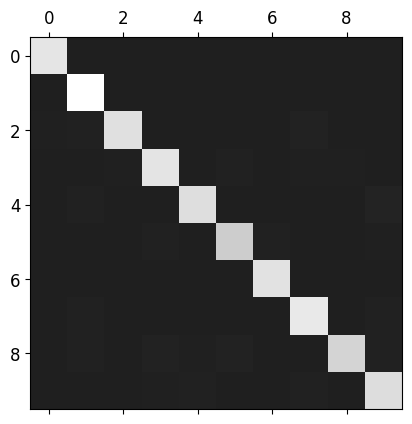

In [119]:
draw_conf_max(mx, 0.88, 'CM_basic_knn_train_set')

In [120]:
avg='weighted'
print(precision_score(y_train, y_predicted, average=avg))

print(recall_score(y_train, y_predicted, average=avg))

print(f1_score(y_train, y_predicted, average=avg))

0.9689912536557207
0.9687678571428572
0.9687049403201283


## True Positive Rate

In [121]:
precision_score(y_train, y_predicted, average=avg)

0.9689912536557207

In [122]:
recall_score(y_train, y_predicted, average=avg)

0.9687678571428572

In [123]:
f1_score(y_train, y_predicted, average=avg)

0.9687049403201283

In [124]:
y_pred = knn_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.9808392857142857

## Learning Curve

Saving figure LC_basic_knn_train_set


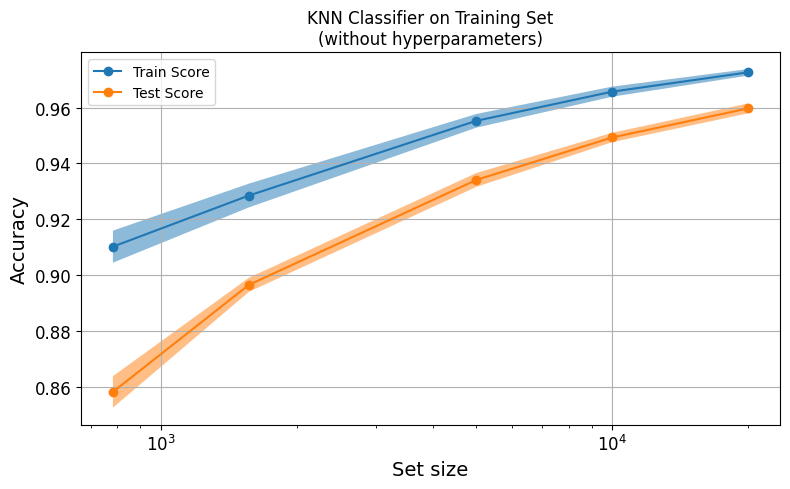

In [125]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": [784, 1568, 5000, 10000, 20000],
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "score_type": "both",
    "score_name": "Accuracy",
    "line_kw": {"marker": "o"},
    "std_display_style": 'fill_between',
}
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(hspace=0.5)

LearningCurveDisplay.from_estimator(knn_clf, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Train Score", "Test Score"])
ax.set_title(f"KNN Classifier on Training Set\n(without hyperparameters)")
ax.set_xlabel("Set size")
ax.grid(True)

save_fig("LC_basic_knn_train_set")

# ROC curve

In [126]:
# y_score = knn_clf.predict_proba(X_train)

# Basic KNN on the Test Set

In [127]:
cross_val_score(knn_clf, X_test, y_test, cv=10, scoring='accuracy')

array([0.95857143, 0.945     , 0.95357143, 0.94428571, 0.95857143,
       0.94642857, 0.94857143, 0.95071429, 0.95      , 0.955     ])

In [128]:
y_test_predicted = cross_val_predict(knn_clf, X_test, y_test, cv=10)

mx = confusion_matrix(y_test, y_test_predicted)

Saving figure CM_basic_knn_test_set


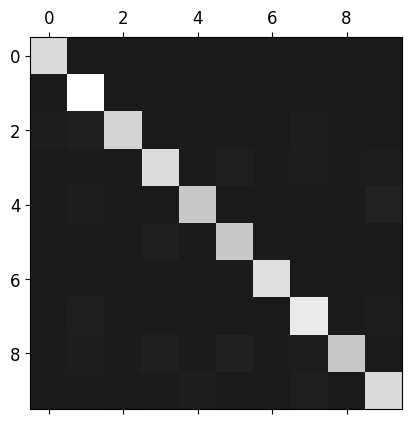

In [129]:
draw_conf_max(mx, fig_name='CM_basic_knn_test_set')

In [130]:
avg='weighted'
print(precision_score(y_test, y_test_predicted, average=avg))

print(recall_score(y_test, y_test_predicted, average=avg))

print(f1_score(y_test, y_test_predicted, average=avg))

0.9517415463269123
0.9510714285714286
0.9509421335192264


In [131]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9700714285714286

## Learning Curve

Saving figure LC_basic_knn_test_set


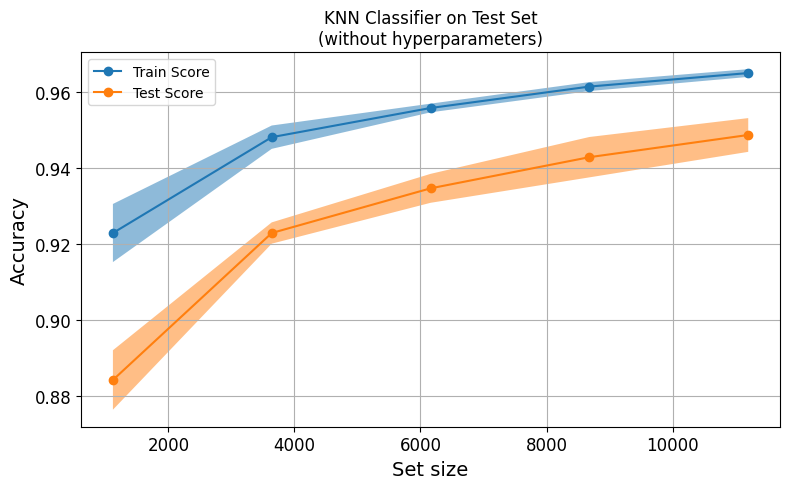

In [ ]:
# common_params = {
#     "X": X_test,
#     "y": y_test,
#     "train_sizes": np.linspace(0.1, 1.0, 5),
#     "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
#     "score_type": "both",
#     "score_name": "Accuracy",
#     "line_kw": {"marker": "o"},
#     "std_display_style": 'fill_between',
# }
# fig, ax = plt.subplots(figsize=(8, 5))
# plt.subplots_adjust(hspace=0.5)

# LearningCurveDisplay.from_estimator(knn_clf, **common_params, ax=ax)
# handles, label = ax.get_legend_handles_labels()
# ax.legend(handles[:2], ["Train Score", "Test Score"])
# ax.set_title(f"KNN Classifier on Test Set\n(without hyperparameters)")
# ax.set_xlabel("Set size")
# ax.grid(True)

save_fig("LC_basic_knn_test_set")

# Hyper Tune

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_neighbors':[3,4,5],'weights':['distance','uniform']}
# ]

# knn_grid_search = GridSearchCV(knn_clf, param_grid=param_grid, cv=5, scoring='accuracy', return_train_score=True)

# knn_grid_search.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['distance', 'uniform']}]"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_neighbors,4


In [ ]:
# save_model(knn_grid_search, 'knn_grid_search')

knn_grid_search = load_model('knn_grid_search')

In [151]:
knn_grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [152]:
knn_grid_search.best_score_

np.float64(0.9721964285714286)

# Validate new model

## Learning Curve

In [153]:
new_knn_clf = knn_grid_search.best_estimator_

Saving figure LC_hyper_knn_train_set_prec


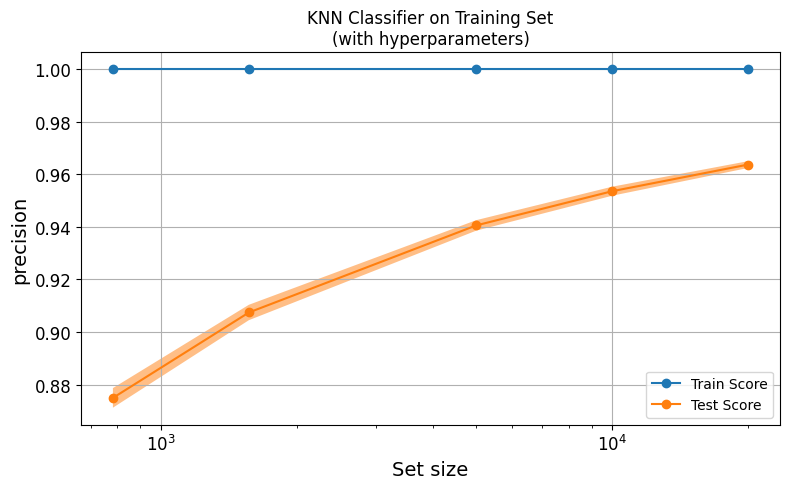

In [154]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": [784, 1568, 5000, 10000, 20000],
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "score_type": "both",
    "score_name": "precision",
    "line_kw": {"marker": "o"},
    "std_display_style": 'fill_between',
}
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(hspace=0.5)

LearningCurveDisplay.from_estimator(new_knn_clf, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Train Score", "Test Score"])
ax.set_title(f"KNN Classifier on Training Set\n(with hyperparameters)")
ax.set_xlabel("Set size")
ax.grid(True)

save_fig("LC_hyper_knn_train_set_prec")

## On Train Set

In [155]:
cross_val_score(new_knn_clf, X_train, y_train, cv=10, scoring='accuracy')

array([0.97053571, 0.97178571, 0.97357143, 0.97357143, 0.97571429,
       0.97571429, 0.97767857, 0.97035714, 0.97285714, 0.97125   ])

In [156]:
y_predicted = cross_val_predict(new_knn_clf, X_train, y_train, cv=5)

mx = confusion_matrix(y_train, y_predicted)

Saving figure CM_hyper_knn_train_set


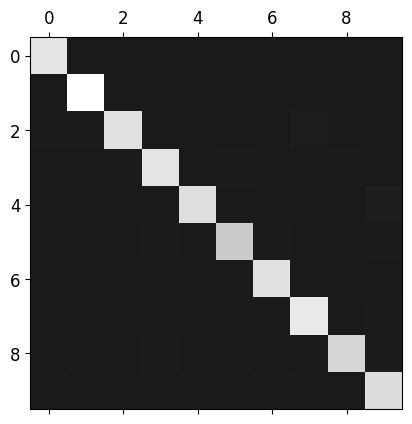

In [157]:
draw_conf_max(mx, alp=0.9, fig_name='CM_hyper_knn_train_set')

In [158]:
avg='weighted'
print(precision_score(y_train, y_predicted, average=avg))

print(recall_score(y_train, y_predicted, average=avg))

print(f1_score(y_train, y_predicted, average=avg))

0.9723574939938495
0.9721964285714285
0.9721570545620394


In [159]:
y_pred = new_knn_clf.predict(X_train)
accuracy_score(y_train, y_pred)

1.0

## On Test Set

In [160]:
cross_val_score(new_knn_clf, X_test, y_test, cv=10, scoring='accuracy')

array([0.96214286, 0.94928571, 0.96      , 0.94642857, 0.96      ,
       0.95428571, 0.95714286, 0.95928571, 0.95928571, 0.95928571])

Saving figure CM_hyper_knn_test_set


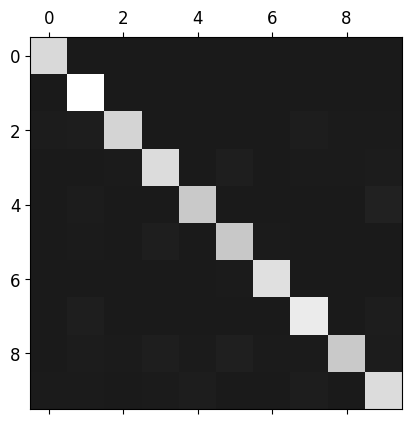

In [161]:
y_predicted = cross_val_predict(new_knn_clf, X_test, y_test, cv=5)

draw_conf_max(confusion_matrix(y_test, y_predicted), fig_name='CM_hyper_knn_test_set')

In [162]:
print(precision_score(y_test, y_predicted, average='weighted'))

print(recall_score(y_test, y_predicted, average='weighted'))

print(f1_score(y_test, y_predicted, average='weighted'))

0.9551833808168264
0.9547142857142857
0.954619345173383


In [163]:
y_pred = new_knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9731428571428572

# Result Note

KNN model without hyperparameters:

|     | precision | recall | f1 | accuracy |
|----|----|----|----|----|
| train | 0.968 | 0.968 | 0.968 | 0.980 |
| test | 0.951 | 0.951 | 0.950 | 0.970 |

KNN model with {'n_neighbors': 4 'weights': 'distance'}

|     | precision | recall | f1 | accuracy |
|----|----|----|----|----|
| train | 0.972 | 0.972 | 0.972 | 1.0 |
| test | 0.955 | 0.954 | 0.954 | 0.9731 |